
## Principal Components Based Decision Tree Regression for Pilot Plant Energy Consumption Data

#### by Athreya Suresh
#### PhD student in Chemical Engineering, McKetta Department of Chemical Engineering, The University of Texas at Austin


### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Jack Xiao, Graduate Student, The University of Texas at Austin
##### [Twitter](https://twitter.com/jackxiao6) | [LinkedIn](https://www.linkedin.com/in/yuchen-jack-xiao-b1b20876/)


### Executive Summary

A decision-tree regression model was built on key predictor features to predict pilot plant energy performance ahead of test campaigns on the field. The predictor features used were linear combinations (principal components) of the most important pilot plant variables that were selected using rigorous feature selection metrics. The model predicted testing data very accurately with a MSE of 0.002 and explained 83% of its variance. Model shortcomings might be explained by fewer principal components used (2 instead of 3) or the limited data availability in this case.

### Background

Carbon capture using amine scrubbing is the most mature tail-end technology that can be retrofitted on coal and natural gas power plants to prevent toxic acid-gases from being emitted into the atmosphere. One such technology used for CO2 capture is the Piperazine Advanced Stripper (PZAS) developed by the Gary Rochelle Research Group at The University of Texas at Austin's McKetta Department of Chemical Engineering. This technology will serve as the case in study for this project.

The PZAS captures CO2 from a power plant up to 98% efficiency using 5 molal Piperazine (PZ) as the solvent. The captured CO2 is stripped out of the solvent using a stripper column with steam as the stripping agent. The large steam requirement for this process stands in the way of large-scale commercial deployment of this process. Steam is often extracted from the power plant this technology serves, and this derates the power plant leading to lower electricity production and steam cycle efficiency. 

My research focuses on bringing down the energy requirement of the CO2 capture process by designing advanced, more thermodynamically reversible process configurations. These configurations are put to test at the pilot scale at The National Carbon Capture Center in Wilsonville, Alabama. Tests happen in large pilot campaigns over several months. During these campaigns, large volumes of data are acquired through the online, sensor-based data acquisition system and sent to UT for analysis. The goal of this project is to leverage this multivariate, volumnous data to better inform decision making. Predicting energy performance using machine learning models well in advance of pilot campaigns helps to strategically plan and test only the most relevant, realistic, low energy process conditions. Predictor features will be carefully selected to aid in the prediction of the response feature, which is the heat rate of the pilot plant. Decision tree regression in the reduced dimension will be used to make predictions of heat rate.



### 1. Import Packages


In [66]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import pandas.plotting as pd_plot       # used in function for visualization
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
from scipy import linalg                  # for linear regression
import random                             # for randon numbers
import seaborn as sns                     # for matrix scatter plots
from sklearn.decomposition import PCA   # for PCA
from sklearn.feature_selection import mutual_info_regression    #for Mutual Information
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split      # train and test split
from sklearn import tree                                  # tree program from scikit learn (package for machine learning)
from sklearn.tree import _tree                            # for accessing tree information
from sklearn import metrics                               # measures to check our models
from sklearn.model_selection import cross_val_score       # cross validation methods
from sklearn.tree import export_graphviz                  # graphical visualization of trees
import math                               # trigonometry etc.

### 2. Set Working Directory


In [2]:
os.chdir(r"C:\Users\sures\Desktop\Subsurface Machine Learning\Project")                     # set the working directory

### 3. Declare Functions

The following functions will be used in the workflow.


In [63]:
#The following code block is from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_PCA.ipynb from GeostatsGuy GitHub.

def partial_corr(C):
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def plot_corr(dataframe,size=10):                         # plots a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    
def visualize_tree(tree,xfeature,yfeature,response,title,):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.RdYlBu
    plot_step = 0.02
    plt.figure(figsize=(8,6))
    x_min, x_max = min(xfeature) - 1, max(xfeature) + 1
    y_min, y_max = min(yfeature) - 1, max(yfeature) + 1
    resp_min = round(min(response)); resp_max = round(max(response));
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    z_min = round(min(response)); z_max = round(max(response))
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max)

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    plt.show()
    
def check_model(model,xfeature,yfeature,response,title):    # plots the estimated vs. the actual  
    predict_train = model.predict(np.c_[xfeature,yfeature])
    plt.scatter(response,predict_train,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.5, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Heat Rate'); plt.ylabel('Estimated Heat Rate')
    plt.xlim(0,1); plt.ylim(0,1)
    plt.arrow(0,0,1,1,width=0.001,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    cor = math.sqrt(metrics.r2_score(response,predict_train))
    print('Mean Squared Error on Testing = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))


### 4. Loading and Cleaning Data

The following workflow applies the .csv file 'Pilot data.csv', which contains steady state time-averaged data from pilot test campaigns in 2018 and 2019. 

We will work with the following predictor features:

* **CO2 Flow Rate (tonne/hr)** - amount of CO2 captured by the plant
* **Rich Solvent Rate (lb/hr)** - solvent flow rate after capturing CO2 from the flue gas
* **Stripper Temp (F)** - measured bottom temperature of the stripper column
* **Stripper Overhead Delta T (F)** - measured temperature difference between solvent entering the stripper column and the gas leaving the stripper column
* **RLDG (mol/mol)** - rich loading, ratio of total CO2 to total alkalinity in the CO2-rich solvent
* **LLDG (mol/mol)** - lean loading, ratio of total CO2 to total alkalinity in CO2-lean solvent
* **PZ conc (m)** - concentration of solvent (Piperazine) in mol PZ/kg water or molality

We will use one or more, or a combination of the above predictor features to predict the response feature:

* **Heat Rate Corrected for Heat Loss (GJ/hr)** - energy in the steam, product of steam flow rate and latent heat of vaporization of steam

In [5]:
#load data into dataframe

df = pd.read_csv('Pilot data.csv')     

#remove negative values where necessary

df = df.drop(df[df['Heat Rate Corrected for Heat Loss (GJ/hr)'] < 0].index)
df = df.drop(df[df['CO2 Flow Rate (tonne/hr)'] == 0].index)
df = df.drop(df[df['CO2 Flow Rate (tonne/hr)'] < 0].index)
df = df.drop(df[df['Rich Solvent Rate (lb/hr)'] == 0].index)
df = df.drop(df[df['Rich Solvent Rate (lb/hr)'] < 0].index)
df = df.drop(df[df['Rich Solvent Rate (lb/hr)'] == 0].index)
df = df.drop(df[df['Rich Solvent Rate (lb/hr)'] < 0].index)
df = df.drop(df[df['Stripper Temp (F)'] == 0].index)
df = df.drop(df[df['Stripper Temp (F)'] < 0].index)
df = df.drop(df[df['RLDG (mol/mol)'] == 0].index)
df = df.drop(df[df['RLDG (mol/mol)'] < 0].index)
df = df.drop(df[df['LLDG (mol/mol)'] == 0].index)
df = df.drop(df[df['LLDG (mol/mol)'] < 0].index)
df = df.drop(df[df['PZ conc (m)'] == 0].index)
df = df.drop(df[df['PZ conc (m)'] < 0].index)
df = df.dropna()

df.describe().transpose()

df.head(n=5)


,Heat Rate Corrected for Heat Loss (GJ/hr),CO2 Flow Rate (tonne/hr),Rich Solvent Rate (lb/hr),Stripper Temp (F),Stripper Overhead Delta T (F),RLDG (mol/mol),LLDG (mol/mol),PZ conc (m)
1,0.313705,0.111477,4510.539663,302.054685,10.150414,0.412395,0.181964,4.65606
2,0.336919,0.129645,5024.113738,302.166115,6.999658,0.409354,0.183600,4.66761
3,0.336132,0.121665,5017.822274,301.793504,4.965790,0.409862,0.185843,4.52000
4,0.338551,0.128000,4979.065438,302.131409,3.840298,0.409207,0.178369,4.54185
5,0.412947,0.150928,6512.127417,301.989294,5.145508,0.407003,0.186616,4.23166


In [6]:
#setting min, max values for features for plotting purposes

CO2min = 0.1; CO2max = 0.4; CO2name = 'CO2 flow (tonne/hr)'; CO2title = 'CO2 flow' # user specified min and max values, and labels for plotting
solventmin = 4000; solventmax = 20000; solventname = 'Rich Solvent Rate (lb/hr)'; solventtitle = 'Rich Solvent Rate'                
strmin = 270; strmax = 322; strname = 'Stripper Temperature (F)'; strtitle = 'Stripper Sump Temperature'
deltmin = -12; deltmax = 25; deltname = 'Stripper Overhead Delta T'; delttitle = 'Stripper Overhead Delta T'
rldgmin = 0.34; rldgmax = 0.42; rldgname = 'Rich Loading (mol CO2/mol N)'; rldgtitle = 'Rich Loading' 
lldgmin = 0.17; lldgmax = 0.27; lldgname = 'Lean Loading (mol CO2/mol N)'; lldgtitle = 'Lean Loading'
PZmin = 3.4; PZmax = 5.6; PZname = 'Solvent Concentration (mol/kg)'; PZtitle = 'Piperazine Concentration'

### 5. Basic Data Checking and Visualization

Shown below are the univariate distributions of the predictor and response features.

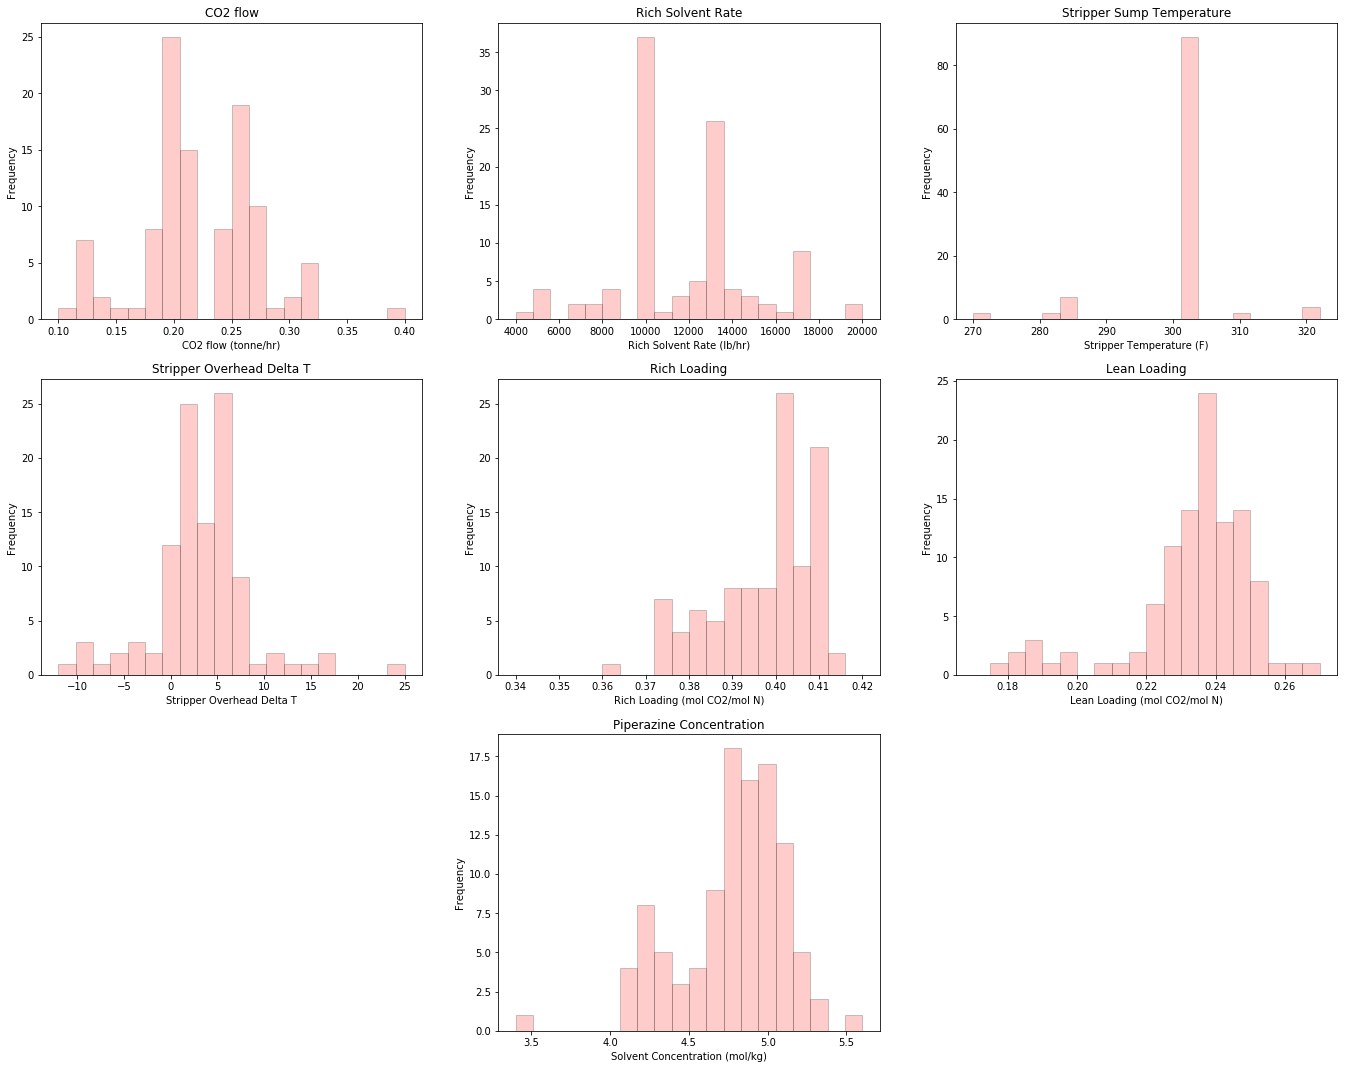

In [8]:
#univariate distributions to identify any outliers or abnormal distributions

plt.subplot(331)
GSLIB.hist_st(df['CO2 Flow Rate (tonne/hr)'].values,CO2min,CO2max,log=False,cumul = False,bins=20,weights = None,xlabel=CO2name,title=CO2title)

plt.subplot(332)
GSLIB.hist_st(df['Rich Solvent Rate (lb/hr)'].values,solventmin,solventmax,log=False,cumul = False,bins=20,weights = None,xlabel=solventname,title=solventtitle)

plt.subplot(333)
GSLIB.hist_st(df['Stripper Temp (F)'].values,strmin,strmax,log=False,cumul = False,bins=20,weights = None,xlabel=strname,title=strtitle)

plt.subplot(334)
GSLIB.hist_st(df['Stripper Overhead Delta T (F)'].values,deltmin,deltmax,log=False,cumul = False,bins=20,weights = None,xlabel=deltname,title=delttitle)

plt.subplot(335)
GSLIB.hist_st(df['RLDG (mol/mol)'].values,rldgmin,rldgmax,log=False,cumul = False,bins=20,weights = None,xlabel=rldgname,title=rldgtitle)

plt.subplot(336)
GSLIB.hist_st(df['LLDG (mol/mol)'].values,lldgmin,lldgmax,log=False,cumul = False,bins=20,weights = None,xlabel=lldgname,title=lldgtitle)

plt.subplot(338)
GSLIB.hist_st(df['PZ conc (m)'].values,PZmin,PZmax,log=False,cumul = False,bins=20,weights = None,xlabel=PZname,title=PZtitle)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.5, wspace=0.2, hspace=0.2)
plt.show()

All the distributions shown above look gaussian and uni-modal. No outliers and unrealistic values are noted. 

Shown below are the bivariate matrix scatter plots between features.

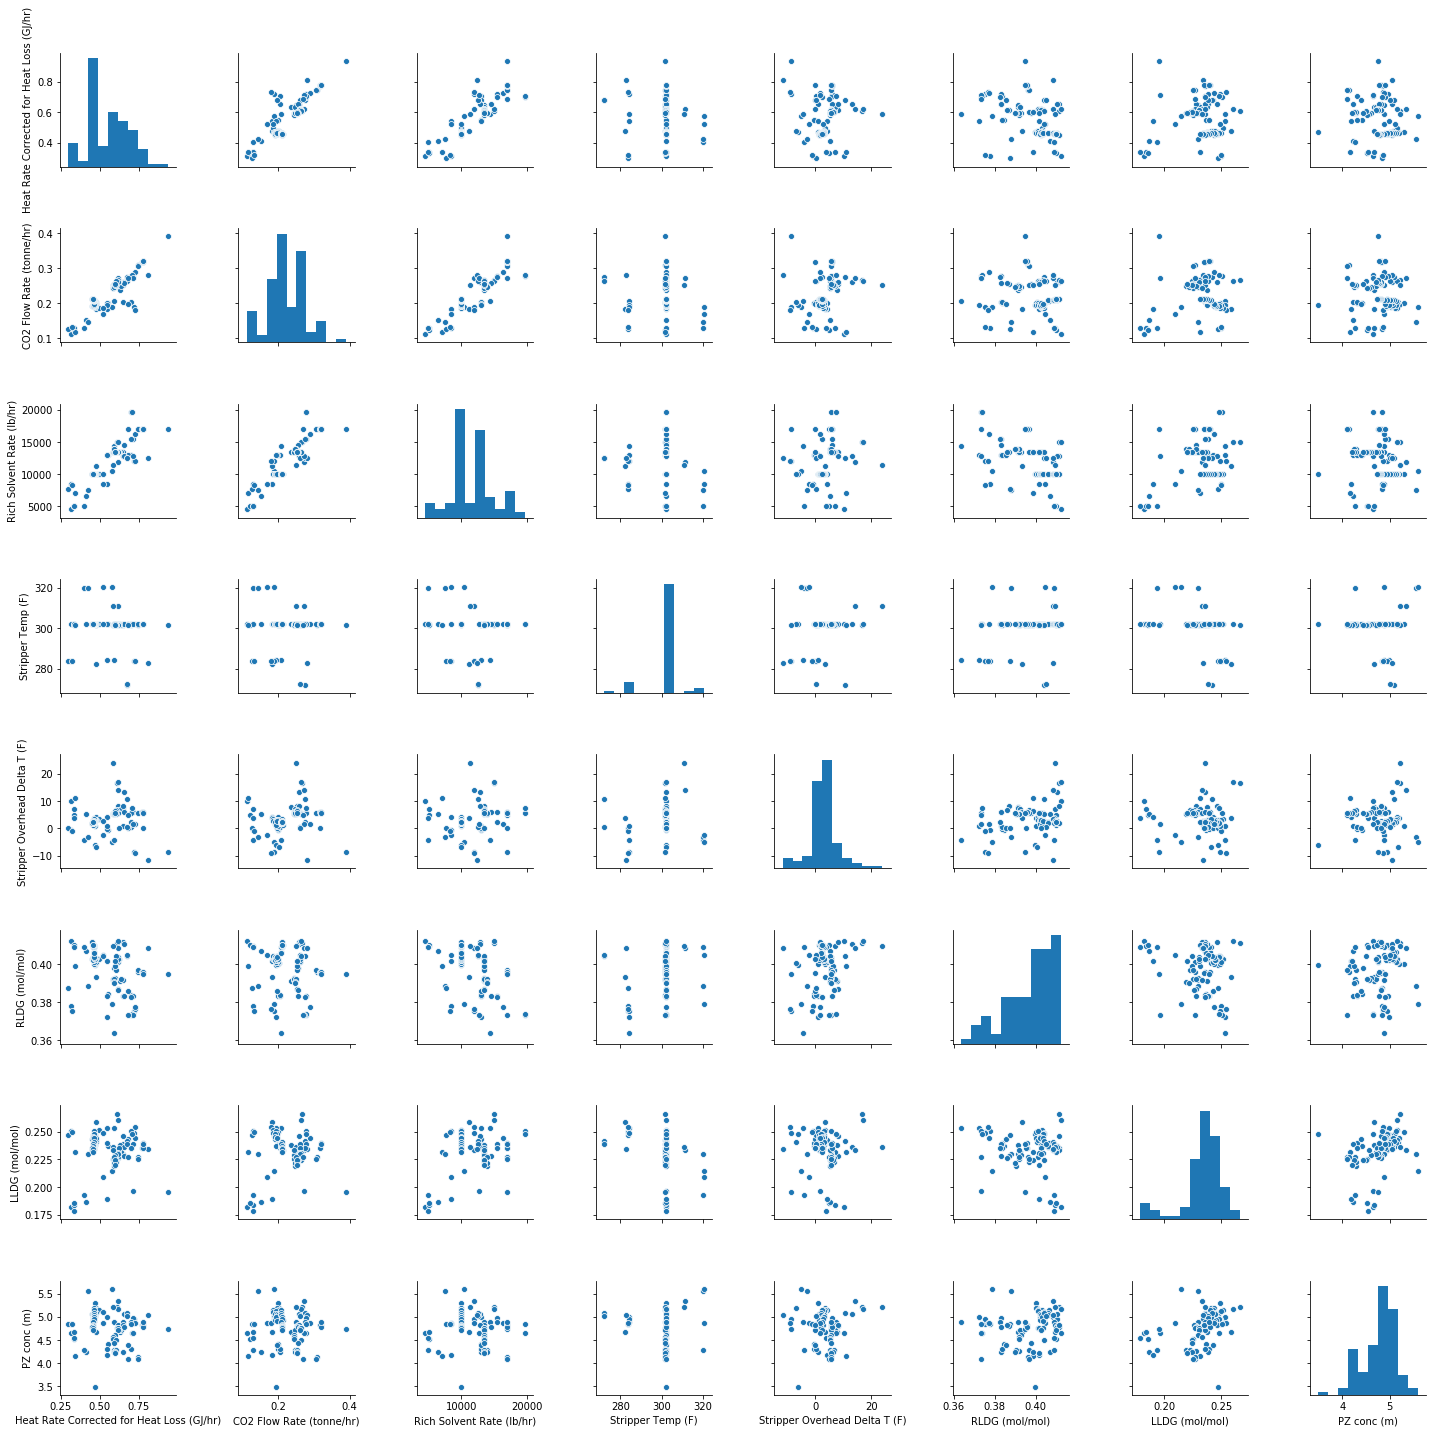

In [9]:
sns.pairplot(df,vars=['Heat Rate Corrected for Heat Loss (GJ/hr)','CO2 Flow Rate (tonne/hr)','Rich Solvent Rate (lb/hr)','Stripper Temp (F)','Stripper Overhead Delta T (F)','RLDG (mol/mol)','LLDG (mol/mol)','PZ conc (m)'],markers='o')

The above bivariate plots are analyzed for any homoscedasticity, heteroscedasticity, and physical constraints in the bivariate relationships.
* A linear dependence between the heat rate and CO2 flow rate and rich solvent flow rate was observed.

There were also linear relationships between predictor features themselves:
* Between rich solvent rate and CO2 flow rate. Greater the rich solvent rate, more the CO2 captured.
* Between rich solvent rate and rich loading.

There were some physical constraints observed:
* Between rich loading and lean loading. The two values fix the CO2 flow rate, and CO2 flow rates were only observed in a given range of values, which are highly dependent on the efficiency of capture.
* Between lean loading and CO2 flow rate.
* Between lean loading and heat rate.
* Between lean loading and rich solvent rate.

No specific non-linear relationships were noted with respect to predictor features - PZ conc, stripper overhead delta T, stripper T.

### 6. Feature Ranking

In order to build an efficient model, the best predictor features must be selected. The correlation coefficient, rank correlation coefficient, partial correlation coefficient, and mutual information between the predictor features and the response feature will be calculated and inferences will be made.

CO2 Flow Rate (tonne/hr)         0.878368
Rich Solvent Rate (lb/hr)        0.877788
Stripper Temp (F)               -0.080634
Stripper Overhead Delta T (F)    0.028960
RLDG (mol/mol)                  -0.377907
LLDG (mol/mol)                   0.080683
PZ conc (m)                     -0.113502
Name: Heat Rate Corrected for Heat Loss (GJ/hr), dtype: float64


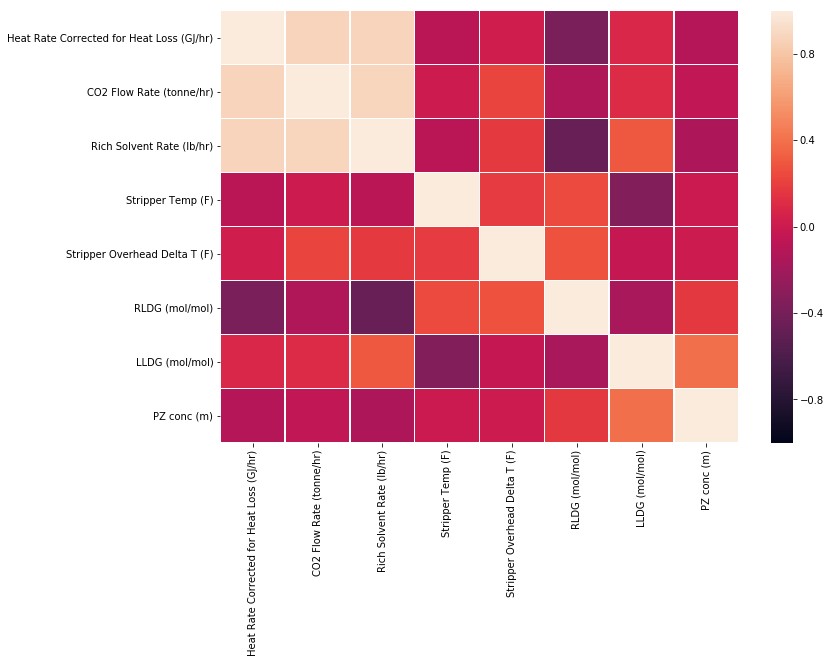

In [10]:
#correlation coefficients

correlation = df.iloc[:,0:8].corr().iloc[0,1:8]
print(correlation)

plt.subplot(111)                          # plot a color coded correlation matrix
sns.heatmap(df.iloc[:,0:8].corr(),vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

Shown below are the rank correlation coefficients. Rank correlation coefficients are updated correlation coefficients after taking into account the effect of any outliers in the feature space.

In [11]:
#rank correlation coefficients

rank_correlation, rank_correlation_pval = stats.spearmanr(df.iloc[:,0:8]) # calculate the rank correlation coefficient
rank_correlation = rank_correlation[0,:][1:8]
print(rank_correlation)

[ 0.76660201  0.84813966 -0.20804143  0.24080974 -0.45392347 -0.04307126
 -0.13737093]


Shown below are the partial correlation coefficients. Partial correlation coefficients are updated correlation coefficients after removing the effect of all other features on a given feature's correlation with the response feature.

In [12]:
#partial correlation coefficients

partial_correlation = partial_corr(df.iloc[:,0:8]) # calculate the partial correlation coefficients
partial_correlation = partial_correlation[0,:][1:8] # extract a single row and remove response feature with itself
print(partial_correlation)

[ 0.17589422  0.46538336 -0.06041599 -0.43165599  0.15224539 -0.32179483
  0.20668193]


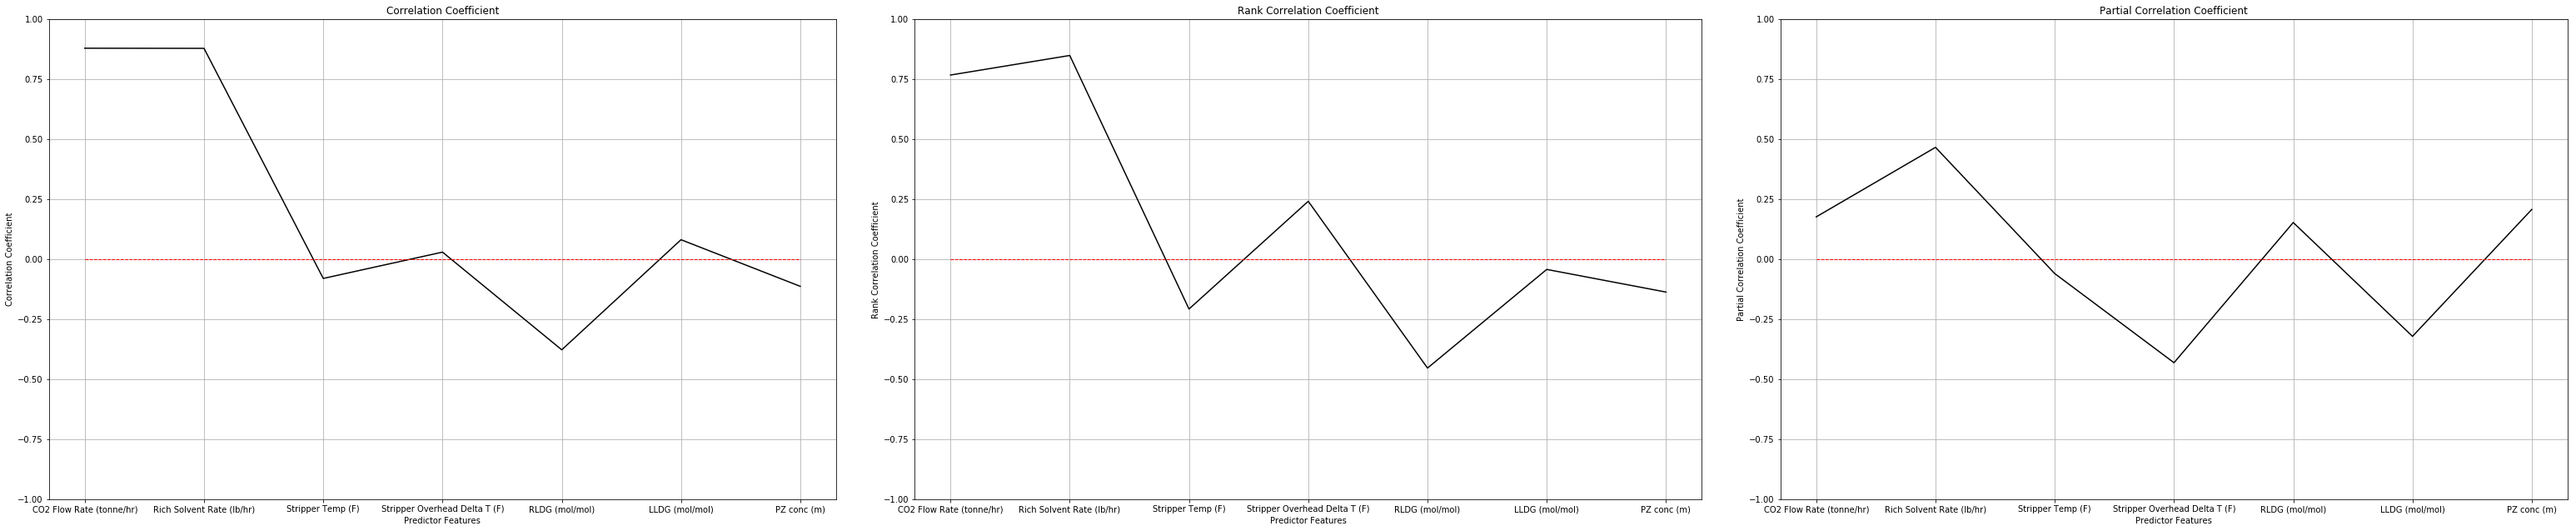

In [17]:
#summarizing correlation coefficients, rank correlation coefficients and partial correlation coefficients

features = df.columns.values[1:8]

plt.subplot(131)          #plotting all correlation coefficients
plt.plot(features,correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(132)          #plotting all rank correlation coefficients
plt.plot(features,rank_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(133)          #plotting all partial correlation coefficients
plt.plot(features,partial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=7, top=2, wspace=0.1, hspace=0.2)
plt.show()

These are the takeaways from the above three plots.

Correlation Coefficient Plot:
* The correlation coefficient plot shows a clear linear relation between CO2 flow rate, rich solvent flow rate and the heat rate of the pilot plant. They have high values of correlation coefficients.
* A slightly negative correlation is observed between heat rate and rich loading.
* The remaining correlation coefficients are around zero.

Rank Correlation Coefficient Plot:
* Rich solvent flow rate appears to now have a higher correlation with heat rate.
* Stripper overhead delta T appears to have a higher correlation with heat rate.
* Correlation coefficients of stripper temperature and lean loading have reduced after accounting for outliers.

Partial Correlation Coefficient Plot:
* CO2 flow rate and rich solvent rate were linearly related to each other. So their partial correlation coefficients with heat rate have both dropped.
* The negative partial correlation coefficients of lean loading and stripper overhead delta T physically make sense. Going into lower regions of lean loading requires more stripping steam energy. Similarly, lower values of stripper overhead delta T progressively makes the solvent colder as it enters the column, demanding higher stripping energy.


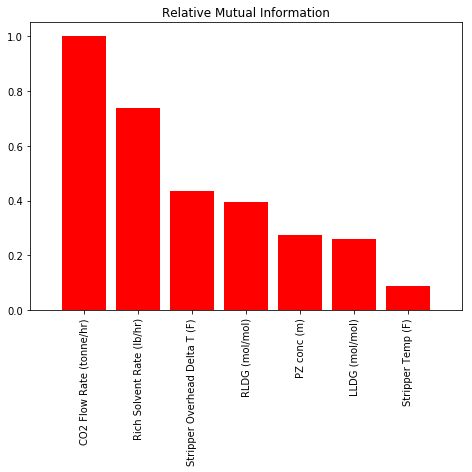

In [21]:
#MUTUAL INFORMATION

x = df.iloc[:,[1,2,3,4,5,6,7]]              # separate DataFrames for predictor and response features
y = df.iloc[:,[0]]

mi = mutual_info_regression(x,np.ravel(y)) # calculate mutual information
mi /= np.max(mi)                          # calculate relative mutual information

indices = np.argsort(mi)[::-1]            # find indicies for descending order

#plt.subplot(111)                          # plot the relative mutual information 
plt.title("Relative Mutual Information")
plt.bar(range(x.shape[1]), mi[indices],
       color="r", align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-1, x.shape[1]])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1., wspace=0.2, hspace=0.2)
plt.show()


The above mutual information plot of predictor features with the response feature will be used as the guide to select features to build the machine learning model. This is because, unlike all the previous indicators of correlation, the mutual information is based on joint probability distribution functions and is closer to the real truth. The top 4 predictor features are CO2 flow rate, rich solvent rate, stripper overhead delta T, and rich loading. However, in order to use all these predictor features, we will have to reduce the dimensionality of the problem to avoid running into overfit issues and multicollinearity issues. Moreover, lean loading is being swapped in for stripper overhead delta T as from practical experience, we have observed that lean loading affects the energy performance greatly.





### 7. Dimensionality Reduction Using Principal Components Analysis


### 7.1. Dropping Unimportant Features from Dataset


In [18]:
#removing all unimportant features from original data set

df1 = df.drop(columns = ['Stripper Temp (F)'])   #dropping the least important feature variable
df1 = df1.drop(columns = ['PZ conc (m)'])
df1 = df1.drop(columns = ['Stripper Overhead Delta T (F)'])
df1 = df1.drop(columns = ['Heat Rate Corrected for Heat Loss (GJ/hr)'])

df1

,CO2 Flow Rate (tonne/hr),Rich Solvent Rate (lb/hr),RLDG (mol/mol),LLDG (mol/mol)
1,0.111477,4510.539663,0.412395,0.181964
2,0.129645,5024.113738,0.409354,0.183600
3,0.121665,5017.822274,0.409862,0.185843
4,0.128000,4979.065438,0.409207,0.178369
5,0.150928,6512.127417,0.407003,0.186616
6,0.182992,8405.583105,0.401872,0.189603
8,0.115825,7007.481014,0.398755,0.231439
10,0.198645,12989.524270,0.384318,0.236567
11,0.199022,13008.746160,0.383394,0.239656
12,0.203506,12991.971340,0.383199,0.238683


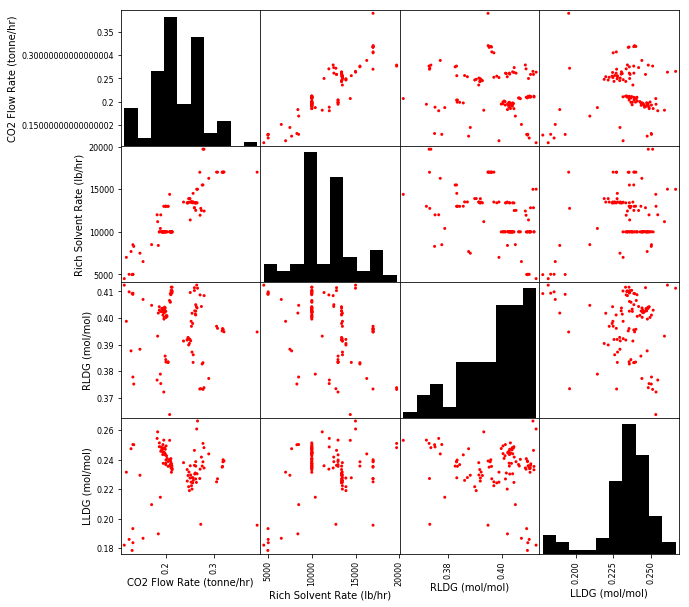

In [19]:
#updated matrix scatter plots

pd_plot.scatter_matrix(df1, alpha = 1,              # pandas matrix scatter plot
    figsize=(10, 10),color = 'red', hist_kwds={'color':['black']})
plt.show()

From the above matrix scatter plots, we see that CO2 flow rate and lean solvent rate are linearly dependent. We also observe linear dependencies between lean loading and rich solvent rate, rich loading and lean loading, rich solvent rate and rich loading, and lean loading and CO2 flow rate. 

It is therefore necessary to reduce the dimensions to orthogonal vector spaces that capture the maximum variance in the original feature space using Principal Components Analysis.


### 7.2. Standardizing Selected Predictor Features for PCA

In this section, predictor features are being standardized for PCA. PCA requires a correlation coefficient matrix of the predictor features, that relies upon the predictor feature values being standardized. The response feature need not be standardized for the purposes of this project. The response feature takes values between 0 and 1.

In [20]:
#standardizing newly selected predictor features - for PCA

features = ['CO2 Flow Rate (tonne/hr)','Rich Solvent Rate (lb/hr)','RLDG (mol/mol)', 'LLDG (mol/mol)']  #predictors
x = df1.loc[:,features].values
x = StandardScaler().fit_transform(x)                     # standardize the data features to mean = 0, var = 1.0
mu = np.mean(x, axis=0)
sd = np.std(x, axis=0)


mu
sd


array([1., 1., 1., 1.])

### 7.3. Pairwise Linear Relationships Between Predictor Features / Multicollinearity


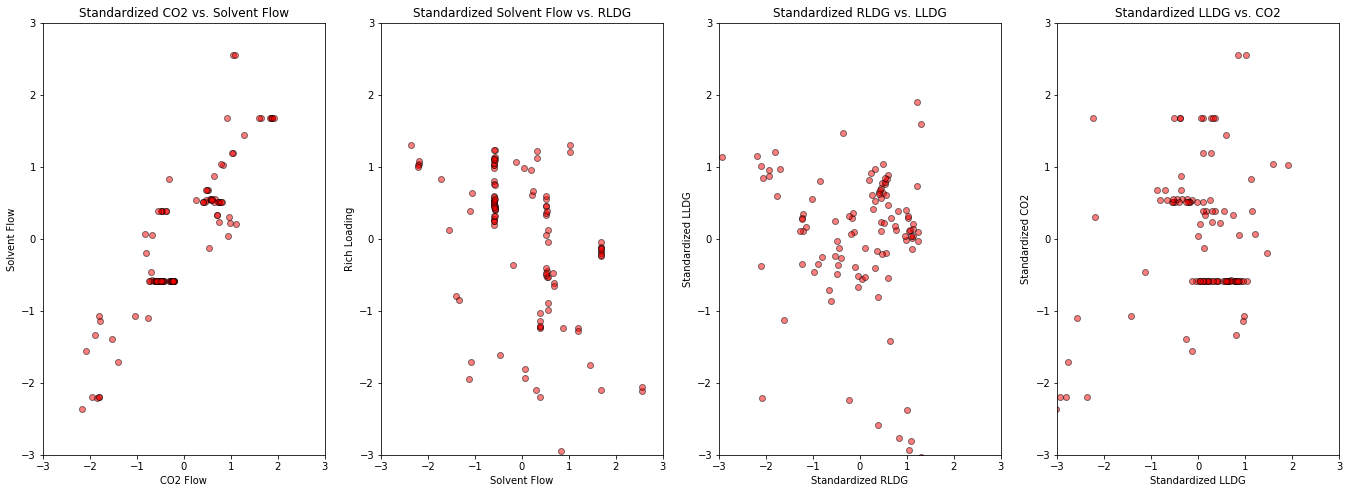

In [21]:
# pairwise relationships between standardized predictor features

plt.subplot(1,4,1)
plt.scatter(x[:,0],x[:,1], s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.5, linewidths=1.0, verts=None, edgecolors="black")
plt.title('Standardized CO2 vs. Solvent Flow'); plt.xlabel('CO2 Flow'); plt.ylabel('Solvent Flow')
plt.xlim([-3,3]); plt.ylim([-3,3])

plt.subplot(1,4,2)
plt.scatter(x[:,1],x[:,2], s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.5, linewidths=1.0, verts=None, edgecolors="black")
plt.title('Standardized Solvent Flow vs. RLDG'); plt.xlabel('Solvent Flow'); plt.ylabel('Rich Loading')
plt.xlim([-3,3]); plt.ylim([-3,3])

plt.subplot(1,4,3)
plt.scatter(x[:,2],x[:,3], s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.5, linewidths=1.0, verts=None, edgecolors="black")
plt.title('Standardized RLDG vs. LLDG'); plt.xlabel('Standardized RLDG'); plt.ylabel('Standardized LLDG')
plt.xlim([-3,3]); plt.ylim([-3,3])


plt.subplot(1,4,4)
plt.scatter(x[:,3],x[:,1], s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.5, linewidths=1.0, verts=None, edgecolors="black")
plt.title('Standardized LLDG vs. CO2'); plt.xlabel('Standardized LLDG'); plt.ylabel('Standardized CO2')
plt.xlim([-3,3]); plt.ylim([-3,3])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3, top=1.5, wspace=0.2, hspace=0.3)
plt.show()

In the above plot, we note that the predictor features are linearly correlated to some degree with each other. It is therefore justified to represent these 4 features as linear combinations of each other at a lower dimension. This is achieved by Principal Components Analysis.

### 7.4. Scree Plot / Variance Explained by PCs

The scree plot below shows the amount of variance in the original predictor feature data that is explained by each principal component. PC1 explains 54 % of the total variance followed by PC2 at 23 % and PC3 at 21 %. PC4 explains the least variance (0.8%). For the purposes of simplifying the regression problem, only the first two principal components will be chosen. It is however acknowledged that the third principal component is almost as important as the second principal component in terms of the variance explained. But, building and visualizing a model in four dimensions (inlcuding the response feature) is challenging.

Variance explained by PC1, and PC2 = [0.54 0.24 0.21 0.01]
First Principal Component explains 54.0 percent of the total variance.
Second Principal Component explains 24.4 percent of the total variance.
Third Principal Component explains 20.8 percent of the total variance.
Fourth Principal Component explains 0.8 percent of the total variance.


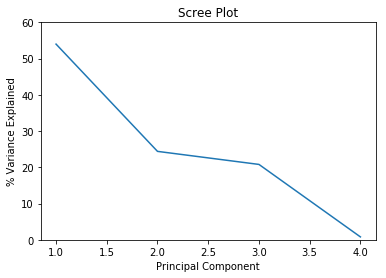

In [22]:
#PCA, using four components, to test scree plot

n_components = 4
pca = PCA(n_components=n_components)
pca.fit(x)
#pca.transform(x)[:,:n_components]   #transformed data in 4 dimensions (4 PCs)
#pca.components_[:n_components,:]     #components are the PCA weights

# scree plot
variance_explained = np.round(pca.explained_variance_ratio_,3)*100
PC = [1,2,3,4]
plt.plot(PC, variance_explained)
plt.xlabel('Principal Component')
plt.ylabel('% Variance Explained')
plt.title('Scree Plot')
plt.ylim(0,60)

print('Variance explained by PC1, and PC2 =', np.round(pca.explained_variance_ratio_,2))
print('First Principal Component explains ' + str(np.round(pca.explained_variance_ratio_[0],3)*100) + ' percent of the total variance.')
print('Second Principal Component explains ' + str(np.round(pca.explained_variance_ratio_[1],3)*100) + ' percent of the total variance.')
print('Third Principal Component explains ' + str(np.round(pca.explained_variance_ratio_[2],3)*100) + ' percent of the total variance.')
print('Fourth Principal Component explains ' + str(np.round(pca.explained_variance_ratio_[3],3)*100) + ' percent of the total variance.')


For the purposes of simplifying the regression problem and for simple data visualization, only the first two principal components are chosen below.

In [23]:
#SELECT ONLY FIRST TWO PRINCIPAL COMPONENTS

n_components = 2
pca = PCA(n_components=n_components)
pca.fit(x)
pca.transform(x)[:,:n_components]   #transformed data in 2 dimensions (2 PCs), visualize the scores
#pca.components_[:n_components,:]     #components are the PCA weights


array([[ 4.16745545e+00,  1.41177316e+00],
       [ 3.72552486e+00,  1.41370767e+00],
       [ 3.79673970e+00,  1.26370195e+00],
       [ 3.83489239e+00,  1.61147887e+00],
       [ 3.03796392e+00,  1.46036506e+00],
       [ 2.05109069e+00,  1.51524310e+00],
       [ 2.32308308e+00, -1.08538022e+00],
       [-4.57433138e-01, -8.31662022e-01],
       [-5.46670014e-01, -9.95940587e-01],
       [-5.84079342e-01, -9.21067932e-01],
       [-5.23092533e-01, -7.69155564e-01],
       [-5.10426514e-01, -1.06974375e+00],
       [ 3.56218802e+00,  9.87473757e-01],
       [ 1.58648438e+00, -1.13542335e+00],
       [ 4.14793022e-01, -3.47975906e-01],
       [ 1.95850747e+00,  6.65302809e-01],
       [ 4.63890980e-02, -1.65332790e+00],
       [ 8.56236779e-01, -2.54125642e+00],
       [ 1.43983737e+00, -2.09038455e+00],
       [ 7.93555610e-01, -2.63612090e+00],
       [-1.79828934e+00, -2.23565718e+00],
       [-1.08260488e+00, -2.07552986e+00],
       [-6.15246926e-01, -1.85663834e+00],
       [-5.

### 8. Data Preparation Before Model Training 

### 8.1. Dataframe with Only Principal Components 1 and 2

In [24]:
#load PC scores of PC2 and PC1 in a separate data frame

title = ['PC1','PC2']
scores = pd.DataFrame(pca.transform(x)[:,:n_components], columns = title)

scores


,PC1,PC2
0,4.167455,1.411773
1,3.725525,1.413708
2,3.796740,1.263702
3,3.834892,1.611479
4,3.037964,1.460365
5,2.051091,1.515243
6,2.323083,-1.085380
7,-0.457433,-0.831662
8,-0.546670,-0.995941
9,-0.584079,-0.921068


### 8.2. Splitting Training, Validation, and Testing Data

A decision tree regression model is going to be used to predict the heat rate from the principal components identified. Since there is quite a bit of scatter in the response feature, I felt that a decision tree would capture this variation with optimized hyperparameters. Decision trees were also chosen for their simplicity. Moreover, no particular shape or relationship was noticed between the PCs and the response feature. Decision trees have the ability to fit a wide variety of shapes in the feature space, and hence is being used. No cross validation will be used in this project. A train, validate, test approach is used.

The train, validate, test approach is used in this project. The training data is 80 % of the total data. Of the remaining 20 % of the data, 50 % is allocated to validation and 50 % is allocated to testing. During the training phase of model building, the model parameters are fitted to the training data. The hyperparameters (number of leaf nodes of this model are then optimized based on the minimum MSE value. This step uses the validation data set to calculate the MSE at each given number of leaf nodes. Finally, a model is trained with the optimized number of leaf nodes with both the training and validation data sets and the model is then tested on the testing dataset to check its performance.

In [38]:
#Using the train, validate, test approach - splitting data sets

y = df.iloc[:,0]    #creating an array for the heat rate (response feature)

x_train, x_untrain, y_train, y_untrain = train_test_split(scores, y, test_size = 0.2, random_state = 7)


#x_untrain.describe()


#x_untrain and y_untrain are the data remaining after the training data has been selected

#splitting remainder of data into validate and test data sets

x_validate, x_test, y_validate, y_test = train_test_split(x_untrain, y_untrain, test_size = 0.5, random_state = 8)

#x_validate.describe()
#x_test.describe()
#x_train.describe()

y_validate

102    0.620835
125    0.775392
65     0.463292
25     0.589083
78     0.614425
16     0.425212
86     0.586270
66     0.458770
116    0.592996
15     0.402268
113    0.592479
Name: Heat Rate Corrected for Heat Loss (GJ/hr), dtype: float64

### 8.3. Visualizing Predictor and Response Features for Training, Validation, and Testing Data

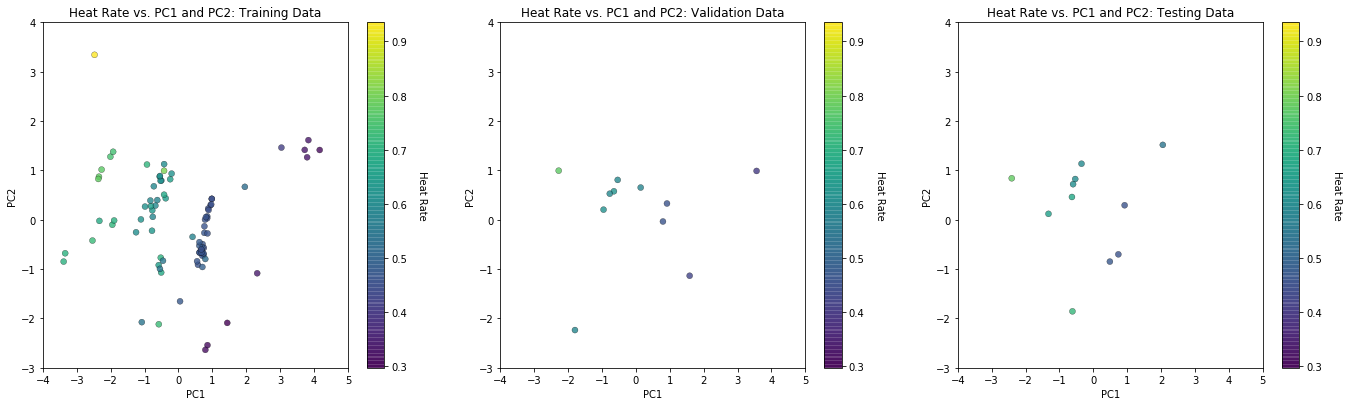

In [65]:
PC1min = min(scores['PC1'])
PC1max = max(scores['PC1'])
PC2min = min(scores['PC2'])
PC2max = max(scores['PC2'])
ymin = min(y)
ymax = max(y)

plt.subplot(131)
im = plt.scatter(x_train["PC1"],x_train["PC2"],s=None, c=y_train, marker=None, cmap=None, norm=None, vmin=ymin, vmax=ymax, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Heat Rate vs. PC1 and PC2: Training Data'); plt.xlabel('PC1'); plt.ylabel('PC2')
plt.xlim(-4,5); plt.ylim(-3,4)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Heat Rate", rotation=270, labelpad=20)

plt.subplot(132)
im = plt.scatter(x_validate["PC1"],x_validate["PC2"],s=None, c=y_validate, marker=None, cmap=None, norm=None, vmin=ymin, vmax=ymax, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Heat Rate vs. PC1 and PC2: Validation Data'); plt.xlabel('PC1'); plt.ylabel('PC2')
plt.xlim(-4,5); plt.ylim(-3,4)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Heat Rate", rotation=270, labelpad=20)

plt.subplot(133)
im = plt.scatter(x_test["PC1"],x_test["PC2"],s=None, c=y_test, marker=None, cmap=None, norm=None, vmin=ymin, vmax=ymax, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Heat Rate vs. PC1 and PC2: Testing Data'); plt.xlabel('PC1'); plt.ylabel('PC2')
plt.xlim(-4,5); plt.ylim(-3,4)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Heat Rate", rotation=270, labelpad=20)


plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

### 9. Model Training

### 9.1. Model MSE Sensitivity with Increasing Number of Leaf Nodes (Done with Validation Data)

MSE calculated with the validation data shows a minimum at 16 leaf nodes. The sensitivity analysis below assumes 1 minimum sample per leaf for all calculations. 16 leaf nodes will be used all the optimum hyperparameter to train the model as it gives the least MSE.

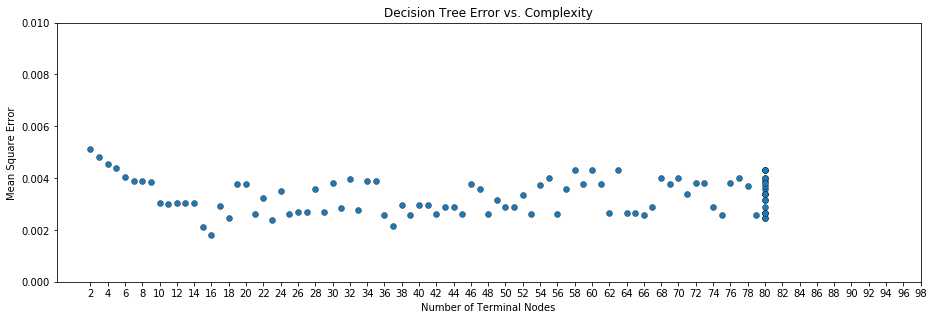

In [51]:
#The first code block is from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_PCA.ipynb from GeostatsGuy GitHub.

#Hyperparameter optimization

trees = []
error = []
var_exp = [] 
nodes = []

inodes = 2
while inodes < 100:
    my_tree = tree.DecisionTreeRegressor(min_samples_leaf=1,max_leaf_nodes=inodes)
    my_tree = my_tree.fit(x_train, y_train)
    trees.append(my_tree)
    #visualize_tree(my_tree,X_train["Por"],X_train["Brittle"],y_train["Prod"],'Training Data and Decision Tree Model, Nodes = ' + str(inodes) )

    predict_train = my_tree.predict(np.c_[x_validate["PC1"],x_validate["PC2"]])
    
    error.append(metrics.mean_squared_error(y_validate,predict_train))
    var_exp.append(metrics.explained_variance_score(y_validate,predict_train))    

    all_nodes = my_tree.tree_.node_count             
    decision_nodes = len([x for x in my_tree.tree_.feature if x != _tree.TREE_UNDEFINED]) 
    terminal_nodes = all_nodes - decision_nodes
    nodes.append(terminal_nodes)
    
    inodes+=1
    
#decision tree validation error vs tree complexity
    
plt.figure(figsize=(8,6))
plt.scatter(nodes,error,s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=1, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Decision Tree Error vs. Complexity'); plt.xlabel('Number of Terminal Nodes'); plt.ylabel('Mean Square Error')
plt.xticks(range(2,100,2)); plt.ylim(0,0.01)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=0.6, wspace=0.2, hspace=0.2)
plt.show()


### 9.2. Training Model with Training and Validation Data with Tuned Hyperparameter

Here we combine the training and the validation data set post hyperparameter tuning to make new training data sets.

In [52]:
#combining training and validation data to retrain the model with optimized hyperparameters

allxdfs = [x_train, x_validate]
allydfs = [y_train, y_validate]

x_retrain = pd.concat(allxdfs)
y_retrain = pd.concat(allydfs)

x_retrain.describe()
y_retrain.describe()

count    95.000000
mean      0.552088
std       0.129756
min       0.297311
25%       0.461360
50%       0.549476
75%       0.633959
max       0.935527
Name: Heat Rate Corrected for Heat Loss (GJ/hr), dtype: float64

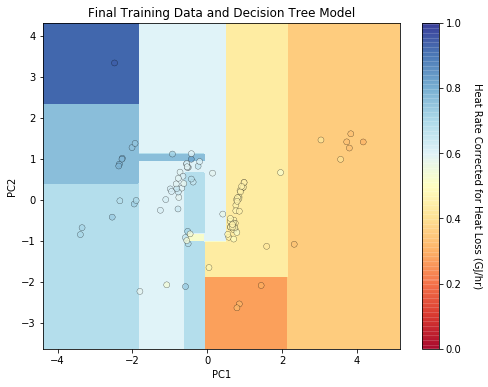

In [53]:
#rebuilding the model with optimized hyperparameters and combined training and validation data

my_tree = tree.DecisionTreeRegressor(min_samples_leaf = 1,max_leaf_nodes = 16)
my_tree = my_tree.fit(x_retrain, y_retrain)

visualize_tree(my_tree,x_retrain["PC1"],x_retrain["PC2"],y_retrain,'Final Training Data and Decision Tree Model')


### 9.3. Testing Model Performance with Testing Data

Model testing shows a MSE of 15 % on testing and 83 % of the variance explained by the model.

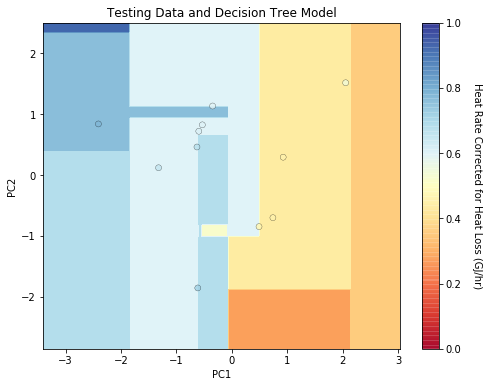

Mean Squared Error on Testing =  0.0 , Variance Explained = 0.83 Cor = 0.87


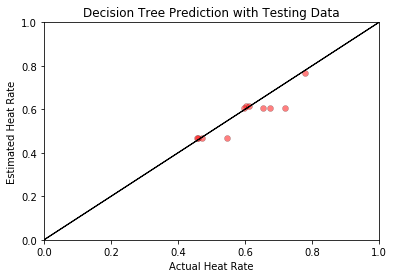

In [64]:
#visualizing tree with testing data

visualize_tree(my_tree,x_test["PC1"],x_test["PC2"],y_test,'Testing Data and Decision Tree Model')
check_model(my_tree,x_test["PC1"],x_test["PC2"],y_test,'Decision Tree Prediction with Testing Data')

### Summary of Results

* 7 initial predictor features were trimmed down to the top 4 features based on multiple feature-ranking metrics. The ultimate indicator of feature importance was the mutual information plot. Stripper Overhead Delta T was replaced with lean loading to due to working knowledge of the process.

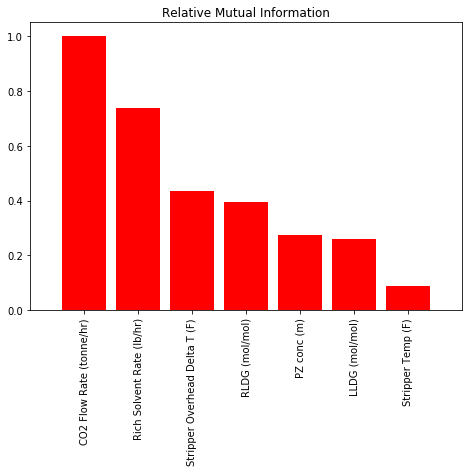


* The 4 finalized predictor features were linearly projected to lower dimensions using principal components analysis. Only the first and second principal components were used to train and test the regression model. The third principal component was discarded albeit being important, due to the increased complexity in visualizing and training the model

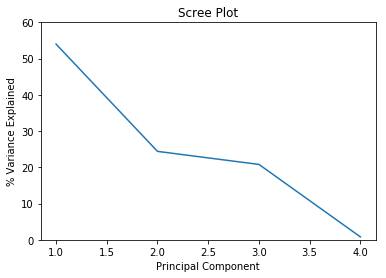


* Time averaged steady state pilot plant data was used to build a 83 % accurate decision tree regression model under reduced dimensions using PCA. The MSE of this model on testing data was only 0.002. This highly accurate model will now be used to predict heat rates from the principal components going forward into pilot plant campaigns of 2021.


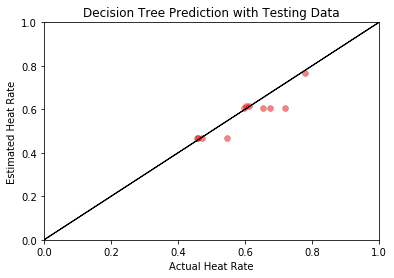


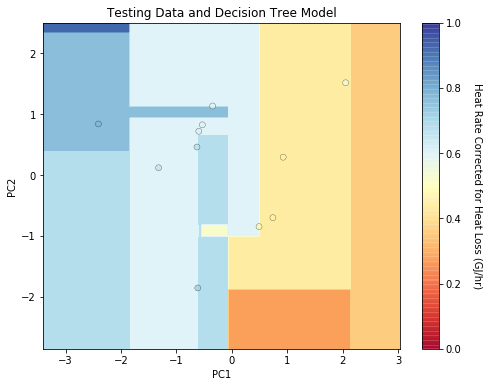



___________________
Athreya is a 3rd year PhD student in chemical engineering working with Dr. Gary Rochelle on process design and optimization of next generation stripping systems for carbon capture and applied gas treating. He is also interested in data science, machine learning and modeling data from process plants to extract the useful information. His interest in data science also extends to subsurface applications relevant to carbon capture, especially in the area of carbon sequestration.
___________________

I am looking for summer internships in 2021 in both mainstream chemical engineering, and data science / machine learning.

I am always eager to learn and discuss!

I hope this was helpful,

*Athreya Suresh*

Email: athreya96@utexas.edu

Disclaimer: The data in this project can be shared without any limitations.

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
